****PART-2****

***Vacuum Cleaner Environment***

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 48.7 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import random


class VacuumCleanerEnv(gym.Env):
    def __init__(self):
        super(VacuumCleanerEnv, self).__init__()
        self.grid_size = 5
        self.state = (0, 0)
        self.dirty_cells = set([(1, 1), (2, 3), (3, 0), (4, 4)])
        self.obstacles = set([(0, 4), (3, 3), (1, 2)])
        self.cleaned_cells = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if (r, c) not in self.dirty_cells and (r, c) not in self.obstacles:
                    self.cleaned_cells.add((r, c))
        # Action space initialisation
        self.action_space = spaces.Discrete(6)
        # Observation space
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),
            spaces.Discrete(self.grid_size)
        ))

    def step(self, action):
        row, col = self.state
        self.previous_state = self.state
        new_state = self.state
        reward = -1  # Any default movement penalty.
        reason = ""
        # Actions and their rewards.
        if action == 0:  # Move up
            if row > 0:
                new_state = (row - 1, col)
                reason = "Moved up"
            else:
                reward = -8
                reason = "Went out of boundary - up"
        elif action == 1:  # Move down
            if row < self.grid_size - 1:
                new_state = (row + 1, col)
                reason = "Moved down"
            else:
                reward = -8
                reason = "Went out of boundary - down"
        elif action == 2:  # Move left
            if col > 0:
                new_state = (row, col - 1)
                reason = "Moved left"
            else:
                reward = -8
                reason = "Went out of boundary - left"
        elif action == 3:  # Move right
            if col < self.grid_size - 1:
                new_state = (row, col + 1)
                reason = "Moved right"
            else:
                reward = -8
                reason = "Went out of boundary - right"
        elif action == 4:  # Clean
            if self.state in self.dirty_cells:
                self.dirty_cells.remove(self.state)
                self.cleaned_cells.add(self.state)
                reward = 20
                reason = "Cleaned dirty cell"
            else:
                reward = -2
                reason = "Cleaned an already clean cell"
        elif action == 5:  # Stay
            reward = -3
            reason = "Stayed in the same position"
        if new_state in self.obstacles:
            reward = -10
            reason = "Ran into an obstacle"
            new_state = self.state
        if new_state != self.state and action in [0, 1, 2, 3]:
            dirty_dist_before = min([abs(row - r) + abs(col - c) for r, c in self.dirty_cells], default=0)
            dirty_dist_after = min([abs(new_state[0] - r) + abs(new_state[1] - c) for r, c in self.dirty_cells], default=0)
            if dirty_dist_after < dirty_dist_before:
                reward = 4
                reason = "Moved closer to dirty cell"
        self.state = new_state
        if self.state in self.dirty_cells and action != 4:
            reward = -5
            reason = "On dirty cell but did not clean"
        done = len(self.dirty_cells) == 0
        return self.state, reward, done, {"reason": reason}

    def reset(self):
        self.state = (0, 0)
        self.dirty_cells = {
            (1, 1), (2, 3), (3, 0), (4, 4)
        }
        self.cleaned_cells = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if (r, c) not in self.dirty_cells and (r, c) not in self.obstacles:
                    self.cleaned_cells.add((r, c))
        return self.state


***SARSA Implementation***

In [ ]:
class SARSAAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Initial exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.q_table = np.zeros((self.env.grid_size, self.env.grid_size, self.env.action_space.n))
        self.initial_q_table = np.copy(self.q_table)  # Initial Q-table for comparison

    def epsilon_greedy(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state])


    def train(self, episodes, max_steps):
        rewards_per_episode = []
        epsilon_values = []
        for episode in range(episodes):
            state = self.env.reset()
            action = self.epsilon_greedy(state)
            total_reward = 0
            for _ in range(max_steps):
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.epsilon_greedy(next_state)
                self.q_table[state][action] += self.alpha * (
                    reward + self.gamma * self.q_table[next_state][next_action] - self.q_table[state][action]
                )
                state, action = next_state, next_action
                total_reward += reward
                if done:
                    break
            self.epsilon *= self.epsilon_decay
            epsilon_values.append(self.epsilon)
            rewards_per_episode.append(total_reward)
        return rewards_per_episode, epsilon_values


    def evaluate(self, episodes, max_steps):
        total_rewards = []
        for _ in range(episodes):
            state = self.env.reset()
            total_reward = 0
            for _ in range(max_steps):
                action = np.argmax(self.q_table[state])  # Always choose the best action
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
                if done:
                    break
            total_rewards.append(total_reward)
        return total_rewards


***Training and Evaluation***

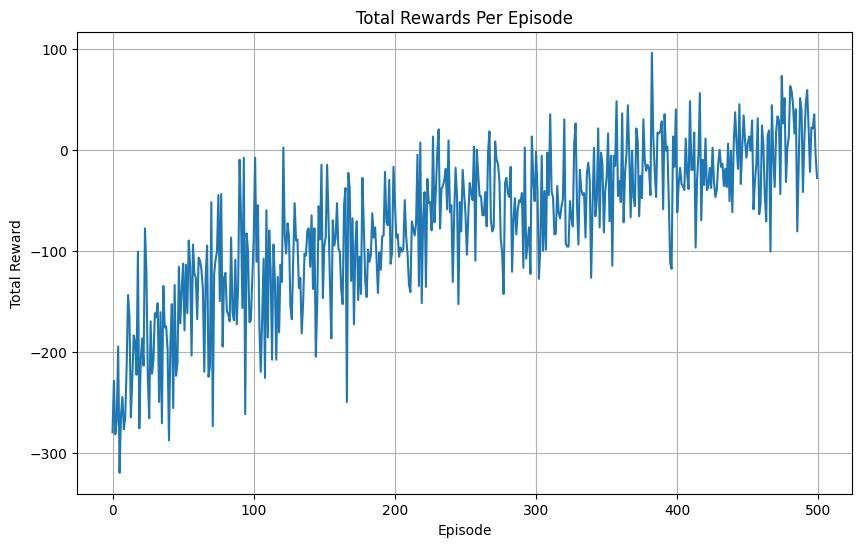

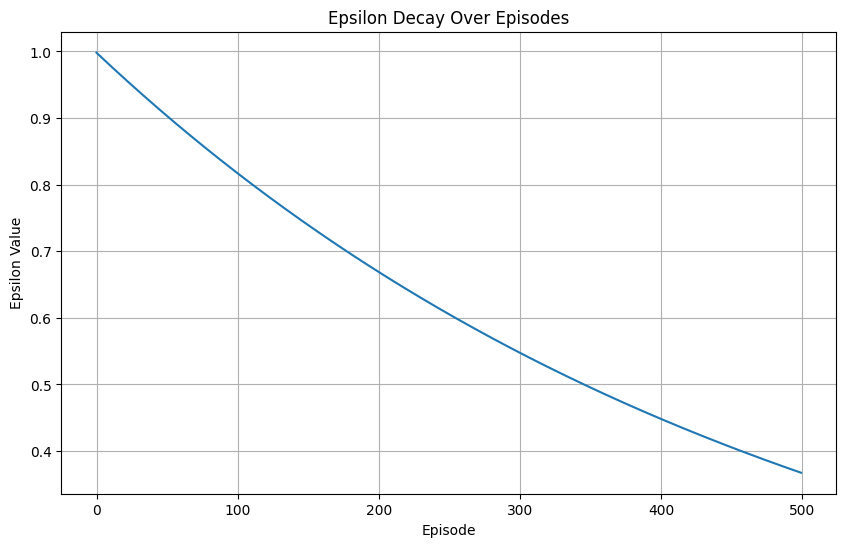

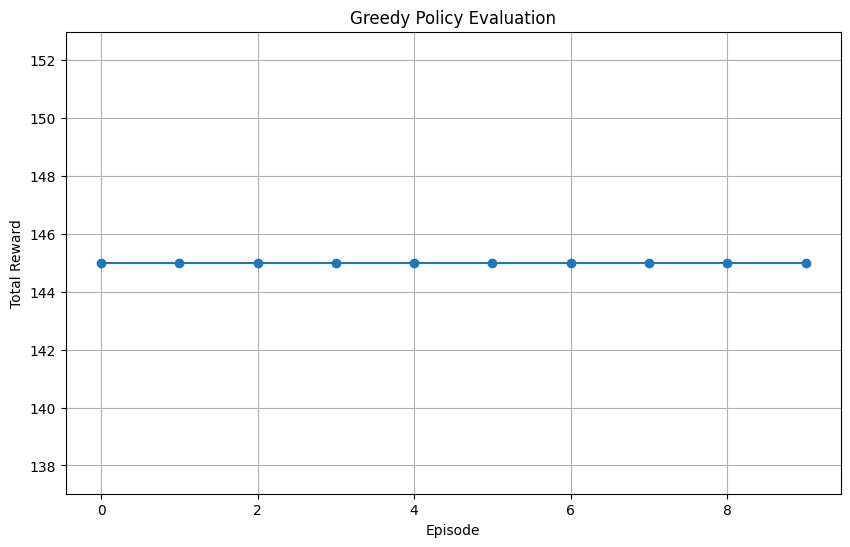


Initial Q-Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]

Trained Q-Table:
[[[-26.25091406 -15.36164106 -26.89363187 -17.10455984 -21.2399976
   -21.35335122]
  [-29.36387885 -19.2669997  -20.13020547 -19.82290255 -22.77634519
   -24.46771554]
  [-28.67156344 -30.98497324 -19.17873141 -19.8554847  -22.37595045
   -23.77238093]
  [-29.12916632 -18.54259355 -20.56451789 -30.39338537 -21.8276697
   -21.66144785]
  [  0.           0.           0.           0.           0.
     0

In [ ]:
env = VacuumCleanerEnv()
agent = SARSAAgent(env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.998)
episodes = 500
max_steps = 100
rewards, epsilons = agent.train(episodes, max_steps)

# Total rewards per episode
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.title("Total Rewards Per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

# Epsilon decay over episodes
plt.figure(figsize=(10, 6))
plt.plot(epsilons)
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon Value")
plt.grid()
plt.show()

# Evaluate greedy policy
greedy_rewards = agent.evaluate(10, max_steps)
plt.figure(figsize=(10, 6))
plt.plot(greedy_rewards, marker='o')
plt.title("Greedy Policy Evaluation")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

# Initial and trained Q-tables
print("\nInitial Q-Table:")
print(agent.initial_q_table)
print("\nTrained Q-Table:")
print(agent.q_table)

***Hyperparameter Tuning***

In [ ]:
gamma_values = [0.9, 0.95, 0.99]
epsilon_decay_values = [0.995, 0.998, 0.999]
best_performance = -float('inf')
best_params = {}
for gamma in gamma_values:
    for epsilon_decay in epsilon_decay_values:
        print(f"\nTraining with Gamma: {gamma}, Epsilon Decay: {epsilon_decay}")
        print("-" * 50)
        # New SARSA agent with hyperparameters
        agent = SARSAAgent(env, alpha=0.1, gamma=gamma, epsilon=1.0, epsilon_decay=epsilon_decay)
        rewards, epsilons = agent.train(episodes=500, max_steps=50)
        # Rewards and epsilon values for every 50 episodes
        for episode, (reward, epsilon) in enumerate(zip(rewards, epsilons)):
            if (episode + 1) % 50 == 0:
                print(f"Episode: {episode + 1}, Reward: {reward:.2f}, Epsilon: {epsilon:.4f}")
        avg_last_10_rewards = np.mean(rewards[-10:])
        # Update the best parameters if performance improves
        if avg_last_10_rewards > best_performance:
            best_performance = avg_last_10_rewards
            best_params = {"gamma": gamma, "epsilon_decay": epsilon_decay}
#Best hyperparameters
print("\nBest Hyperparameters:")
print(f"Gamma: {best_params['gamma']}, Epsilon Decay: {best_params['epsilon_decay']}")



Training with Gamma: 0.9, Epsilon Decay: 0.995
--------------------------------------------------
Episode: 50, Reward: -51.00, Epsilon: 0.7783
Episode: 100, Reward: -27.00, Epsilon: 0.6058
Episode: 150, Reward: -2.00, Epsilon: 0.4715
Episode: 200, Reward: -24.00, Epsilon: 0.3670
Episode: 250, Reward: 26.00, Epsilon: 0.2856
Episode: 300, Reward: 17.00, Epsilon: 0.2223
Episode: 350, Reward: 33.00, Epsilon: 0.1730
Episode: 400, Reward: 66.00, Epsilon: 0.1347
Episode: 450, Reward: 60.00, Epsilon: 0.1048
Episode: 500, Reward: 49.00, Epsilon: 0.0816

Training with Gamma: 0.9, Epsilon Decay: 0.998
--------------------------------------------------
Episode: 50, Reward: -76.00, Epsilon: 0.9047
Episode: 100, Reward: -26.00, Epsilon: 0.8186
Episode: 150, Reward: -129.00, Epsilon: 0.7406
Episode: 200, Reward: -10.00, Epsilon: 0.6701
Episode: 250, Reward: -25.00, Epsilon: 0.6062
Episode: 300, Reward: -11.00, Epsilon: 0.5485
Episode: 350, Reward: 55.00, Epsilon: 0.4962
Episode: 400, Reward: -37.00,

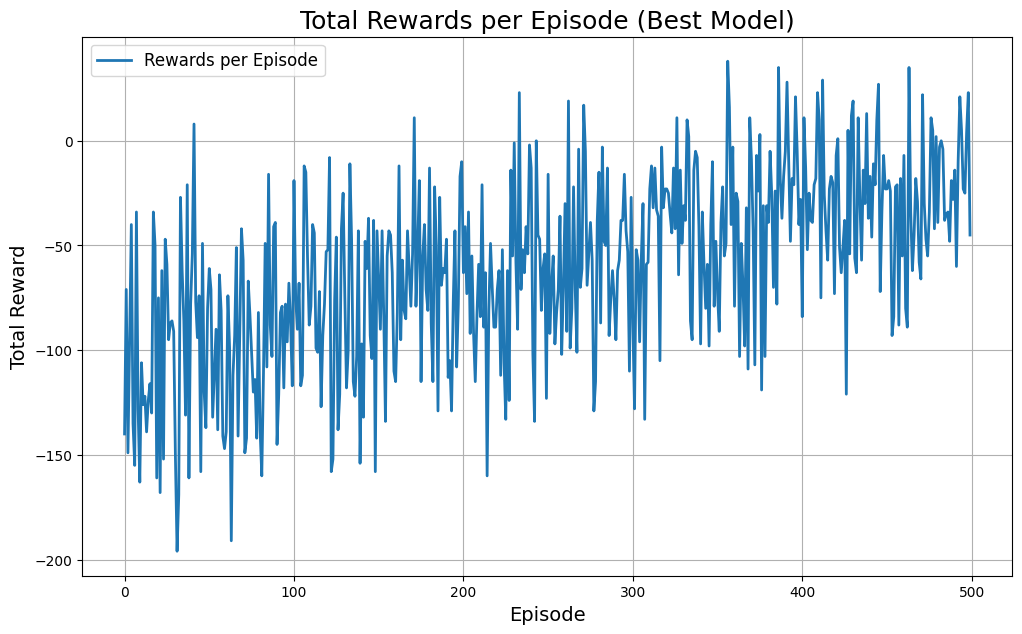

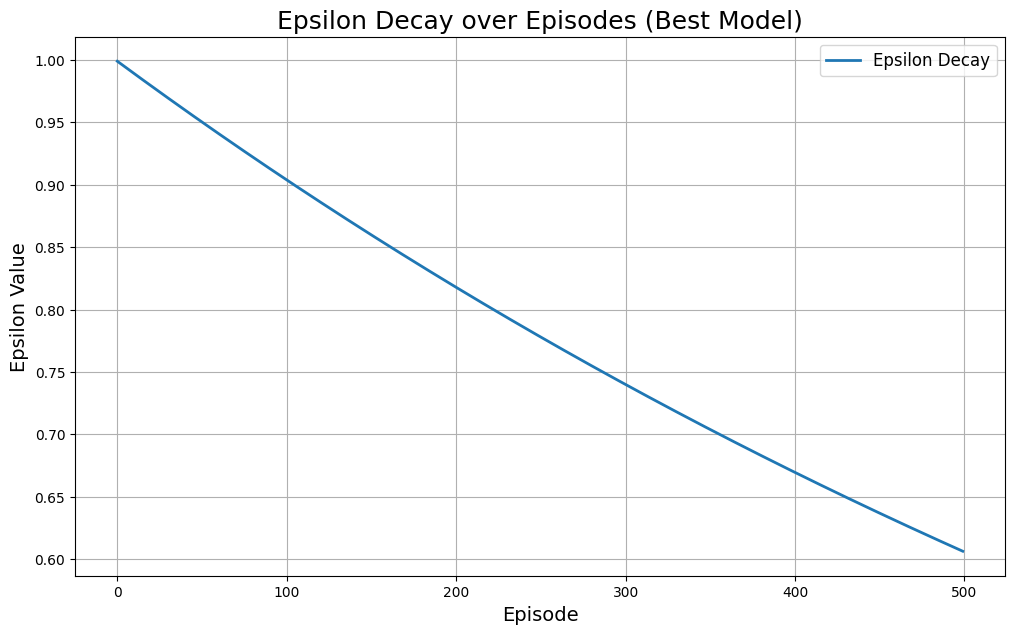

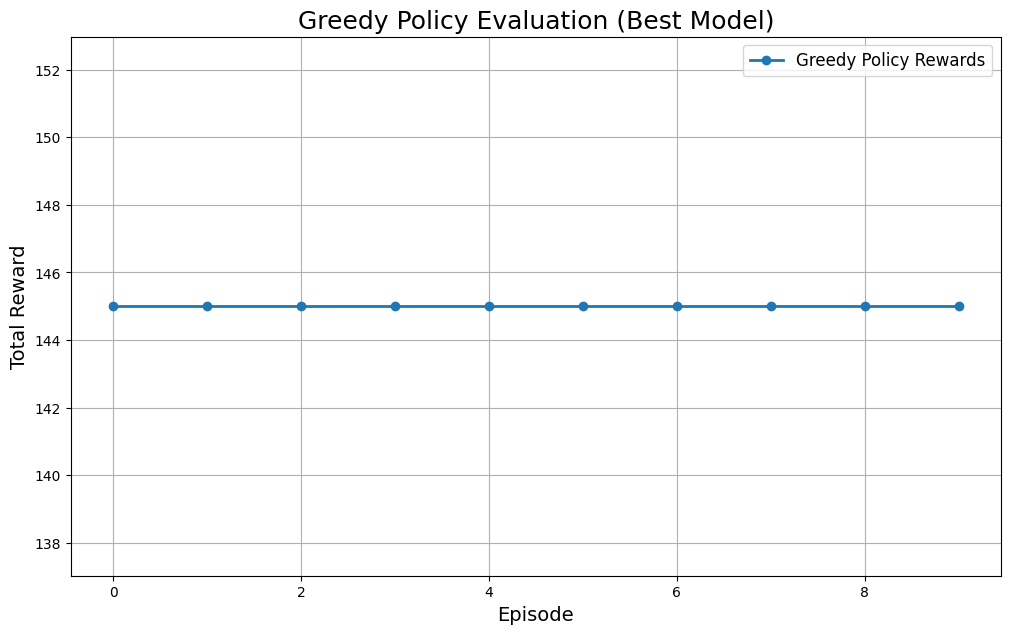

In [ ]:
#Total Rewards for Best Model
plt.figure(figsize=(12, 7))
plt.plot(rewards, label="Rewards per Episode", linewidth=2)
plt.title("Total Rewards per Episode (Best Model)", fontsize=18)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Epsilon Decay for Best Model
plt.figure(figsize=(12, 7))
plt.plot(epsilons, label="Epsilon Decay", linewidth=2)
plt.title("Epsilon Decay over Episodes (Best Model)", fontsize=18)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon Value", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Greedy Policy Evaluation Graph
plt.figure(figsize=(12, 7))
plt.plot(greedy_rewards, marker='o', label="Greedy Policy Rewards", linewidth=2)
plt.title("Greedy Policy Evaluation (Best Model)", fontsize=18)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


Part - III

In [ ]:
class DoubleQAgent:
    def __init__(self, env, n_steps, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Initial exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.epsilon_min = epsilon_min  # Minimum value for epsilon
        self.n_steps = n_steps  # n-step for the n-step Q-learning
        self.q1_table = np.zeros((self.env.grid_size, self.env.grid_size, self.env.action_space.n))
        self.q2_table = np.zeros((self.env.grid_size, self.env.grid_size, self.env.action_space.n))

    def epsilon_greedy(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        q1_action = np.argmax(self.q1_table[state])
        q2_action = np.argmax(self.q2_table[state])
        return q1_action if self.q1_table[state][q1_action] > self.q2_table[state][q2_action] else q2_action

    def train(self, episodes, max_steps):
        rewards_per_episode = []
        epsilon_values = []
        for episode in range(episodes):
            state = self.env.reset()
            actions = [self.epsilon_greedy(state)] * self.n_steps  # Keep a list of actions for n steps
            states = [state] * self.n_steps
            rewards = [0] * self.n_steps
            total_reward = 0
            for step in range(max_steps):
                next_state, reward, done, _ = self.env.step(actions[-1])
                rewards.append(reward)
                states.append(next_state)
                actions.append(self.epsilon_greedy(next_state))

                # Update the Q-tables using n-step return
                if len(rewards) > self.n_steps:
                    G = sum([self.gamma**i * rewards[-i-1] for i in range(self.n_steps)]) + self.gamma**self.n_steps * np.max(self.q1_table[next_state])
                    update_q_table = self.q1_table if random.random() < 0.5 else self.q2_table
                    update_action = actions[-self.n_steps]
                    update_q_table[states[-self.n_steps]][update_action] += self.alpha * (G - update_q_table[states[-self.n_steps]][update_action])

                state = next_state
                actions.pop(0)
                states.pop(0)
                rewards.pop(0)
                total_reward += reward
                if done:
                    break

            # Epsilon decay without going below epsilon_min
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            epsilon_values.append(self.epsilon)
            rewards_per_episode.append(total_reward)
        return rewards_per_episode, epsilon_values

    def evaluate(self, episodes, max_steps):
        total_rewards = []
        for _ in range(episodes):
            state = self.env.reset()
            total_reward = 0
            for _ in range(max_steps):
                action = np.argmax(self.q1_table[state] + self.q2_table[state])  # Action selection based on both Q-tables
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
                if done:
                    break
            total_rewards.append(total_reward)
        return total_rewards

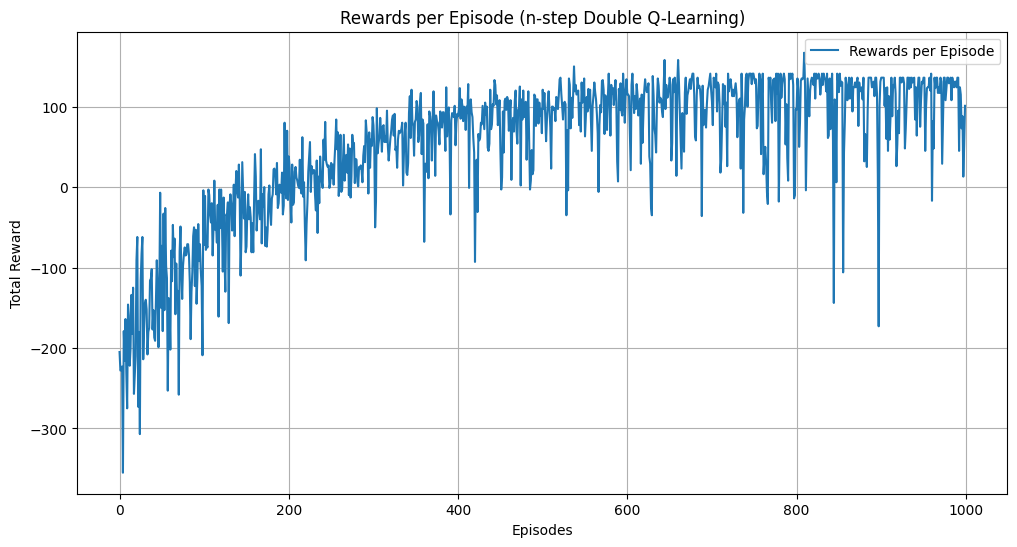

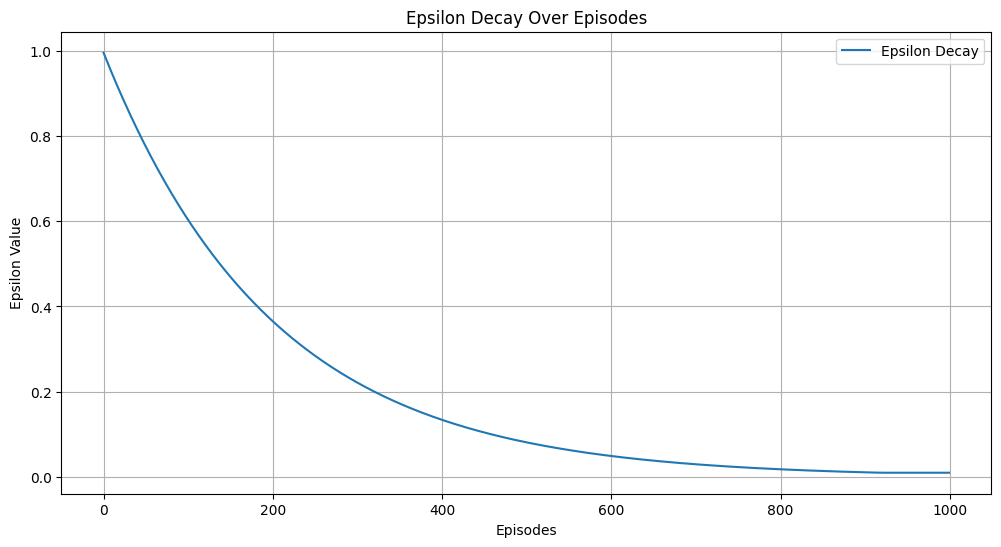

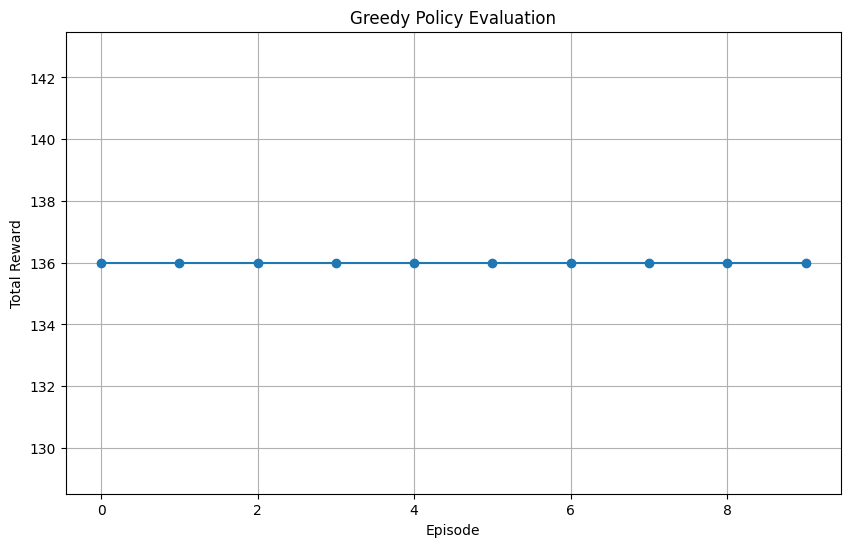


Trained Q1-Table:
[[[ 81.65304501  80.5081339   83.94596808 124.10383208  87.32813132
    97.63467138]
  [ 22.28579928 103.48637703  62.52081588  63.73710792  53.79792662
    61.34549538]
  [-15.10196447  -7.01008057 109.68366899  -9.81526431  -2.74330462
   -12.89778949]
  [-21.59322789 -10.56481488  65.85147022 -15.85383915  14.28537279
   -14.73765357]
  [  0.           0.           0.           0.           0.
     0.        ]]

 [[  7.46126285   0.18876905  -9.31026328  87.65904651  25.11152506
     3.84359862]
  [ 41.1643753  147.57505183  69.53432787  28.02202964 101.84425008
    44.34959512]
  [  0.           0.           0.           0.           0.
     0.        ]
  [ 78.27569458 -16.11503816 -21.02599026 -14.68355379 -12.823354
   -15.4261842 ]
  [-25.90027444 -14.76601972  -4.86115328 -22.28802369 -19.33544037
   -16.02538664]]

 [[  9.49350238   6.80975382  -5.35511588  94.77023467   4.64695764
    -0.51985884]
  [ 78.51822506 104.26971961  61.54893829  83.04755801  60.2

In [ ]:
#Running Double Q Agent
env = VacuumCleanerEnv()
agent = DoubleQAgent(env, n_steps=5, alpha=0.2, gamma=0.99, epsilon=1.0, epsilon_decay=0.995)
episodes = 1000
max_steps = 100
rewards, epsilons = agent.train(episodes, max_steps)

plt.figure(figsize=(12, 6))
plt.plot(range(episodes), rewards, label='Rewards per Episode')
plt.title('Rewards per Episode (n-step Double Q-Learning)')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()
plt.show()

# Plotting the epsilon decay over episodes
plt.figure(figsize=(12, 6))
plt.plot(range(episodes), epsilons, label='Epsilon Decay')
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.legend()
plt.show()

# Evaluate greedy policy
greedy_rewards = agent.evaluate(10, max_steps)
plt.figure(figsize=(10, 6))
plt.plot(greedy_rewards, marker='o')
plt.title("Greedy Policy Evaluation")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

# After training, print the Q-tables
print("\nTrained Q1-Table:")
print(agent.q1_table)  # This is the Q1 table after training

print("\nTrained Q2-Table:")
print(agent.q2_table)  # This is the Q2 table after training

In [ ]:
gamma_values = [0.9, 0.95, 0.99]
epsilon_decay_values = [0.995, 0.998, 0.999]
epsilon_min_values = [0.01, 0.05, 0.1]
epsilon_max_values = [1.0]
episode_values = [300, 400, 500]
max_timesteps_values = [50, 100, 150]

best_performance = -float('inf')
double_Q_best_params = {}

# Loop through the hyperparameters grid
for gamma in gamma_values:
    for epsilon_decay in epsilon_decay_values:
        for epsilon_min in epsilon_min_values:
            for epsilon_max in epsilon_max_values:
                for episodes in episode_values:
                    for max_steps in max_timesteps_values:
                        print(f"\nTraining with Gamma: {gamma}, Epsilon Decay: {epsilon_decay}, Epsilon Min: {epsilon_min}, Epsilon Max: {epsilon_max}, Episodes: {episodes}, Max Timesteps: {max_steps}")
                        print("-" * 50)

                        # Initialize the DoubleQAgent with the given hyperparameters
                        agent = DoubleQAgent(
                            env,
                            n_steps=5,
                            alpha=0.1,
                            gamma=gamma,
                            epsilon=epsilon_max,
                            epsilon_decay=epsilon_decay,
                            epsilon_min=epsilon_min
                        )

                        # Train the agent for the specified number of episodes and max steps per episode
                        rewards, epsilons = agent.train(episodes=episodes, max_steps=max_steps)

                        # Print the rewards and epsilon values every 50 episodes
                        for episode, (reward, epsilon) in enumerate(zip(rewards, epsilons)):
                            if (episode + 1) % 50 == 0:
                                print(f"Episode: {episode + 1}, Reward: {reward:.2f}, Epsilon: {epsilon:.4f}")

                        # Calculate the average rewards to evaluate performance
                        avg_all_rewards = np.mean(rewards)
                        if avg_all_rewards > best_performance:
                            best_performance = avg_all_rewards
                            double_Q_best_params = {
                                "gamma": gamma,
                                "epsilon_decay": epsilon_decay,
                                "epsilon_min": epsilon_min,
                                "epsilon_max": epsilon_max,
                                "episodes": episodes,
                                "max_timesteps": max_steps
                            }




Training with Gamma: 0.9, Epsilon Decay: 0.995, Epsilon Min: 0.01, Epsilon Max: 1.0, Episodes: 300, Max Timesteps: 50
--------------------------------------------------
Episode: 50, Reward: -46.00, Epsilon: 0.7783
Episode: 100, Reward: -82.00, Epsilon: 0.6058
Episode: 150, Reward: -32.00, Epsilon: 0.4715
Episode: 200, Reward: 12.00, Epsilon: 0.3670
Episode: 250, Reward: 12.00, Epsilon: 0.2856
Episode: 300, Reward: -7.00, Epsilon: 0.2223

Training with Gamma: 0.9, Epsilon Decay: 0.995, Epsilon Min: 0.01, Epsilon Max: 1.0, Episodes: 300, Max Timesteps: 100
--------------------------------------------------
Episode: 50, Reward: -81.00, Epsilon: 0.7783
Episode: 100, Reward: -162.00, Epsilon: 0.6058
Episode: 150, Reward: 47.00, Epsilon: 0.4715
Episode: 200, Reward: 32.00, Epsilon: 0.3670
Episode: 250, Reward: 35.00, Epsilon: 0.2856
Episode: 300, Reward: 64.00, Epsilon: 0.2223

Training with Gamma: 0.9, Epsilon Decay: 0.995, Epsilon Min: 0.01, Epsilon Max: 1.0, Episodes: 300, Max Timesteps:

In [ ]:
# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(f"Gamma: {double_Q_best_params['gamma']}, Epsilon Decay: {double_Q_best_params['epsilon_decay']}, Epsilon Min: {double_Q_best_params['epsilon_min']}, Epsilon Max: {double_Q_best_params['epsilon_max']}, Episodes: {double_Q_best_params['episodes']}, Max Timesteps: {double_Q_best_params['max_timesteps']}")


Best Hyperparameters:
Gamma: 0.95, Epsilon Decay: 0.995, Epsilon Min: 0.01, Epsilon Max: 1.0, Episodes: 500, Max Timesteps: 150



Training with n = 1

Initial Q-tables for n = 1:
Initial Q1 Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
Initial Q2 Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 

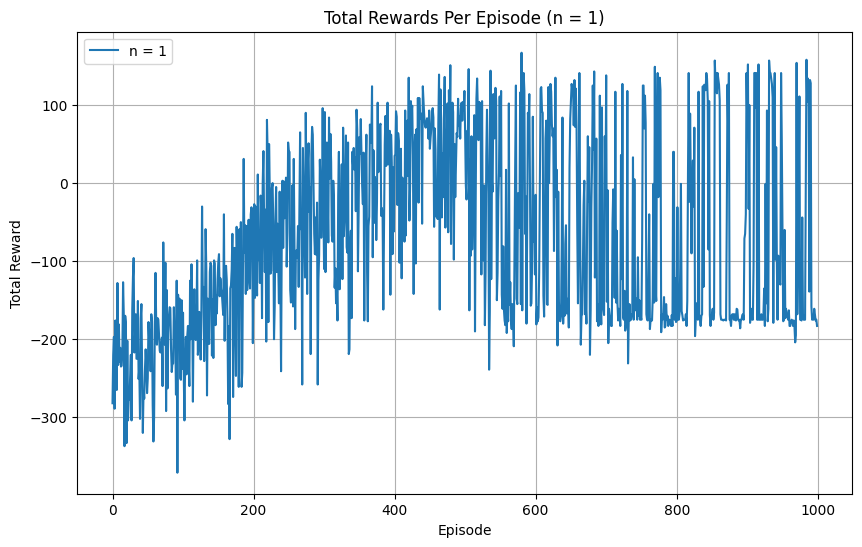

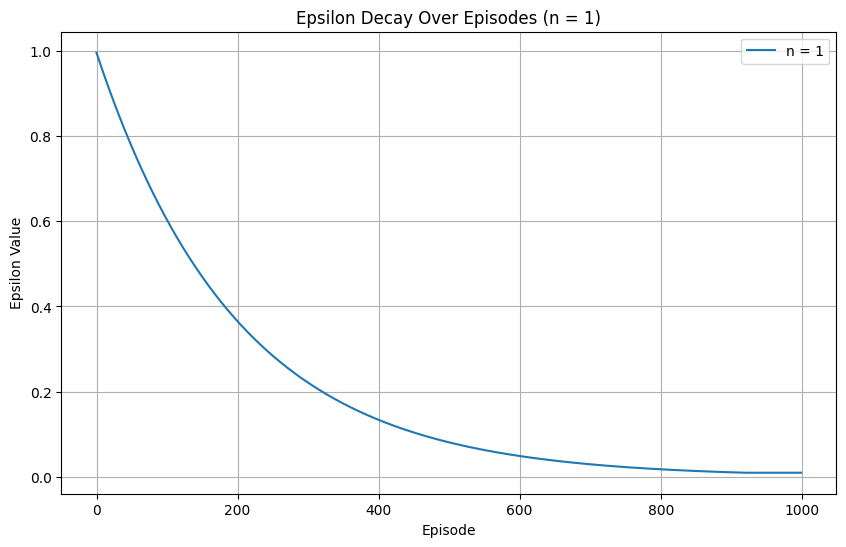

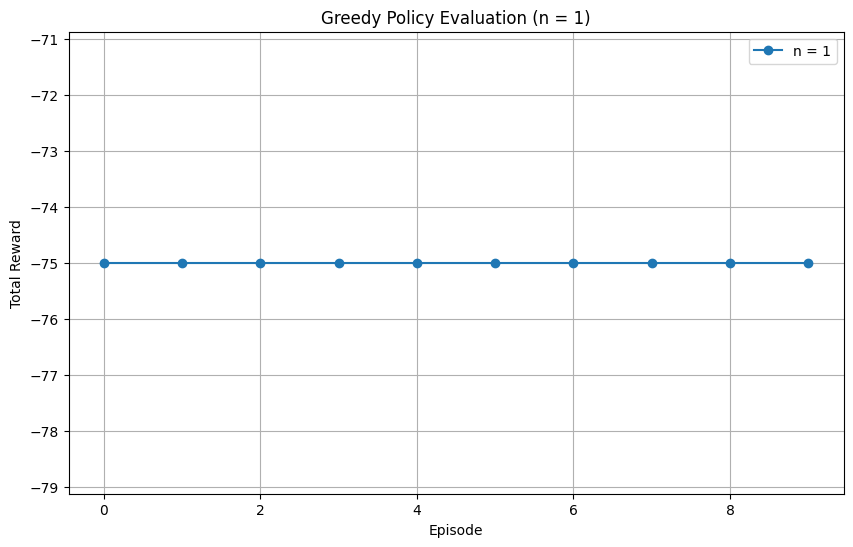

Average greedy reward for n = 1: -75.0

Training with n = 2

Initial Q-tables for n = 2:
Initial Q1 Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
Initial Q2 Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [

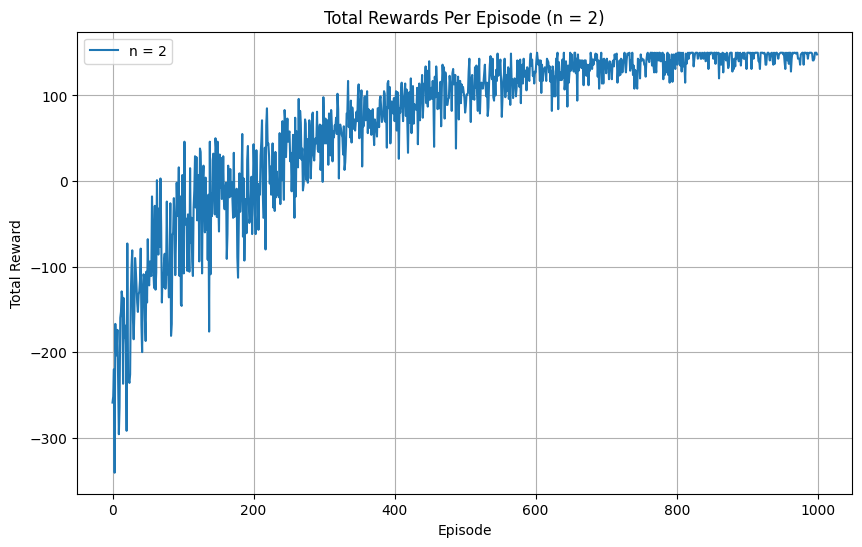

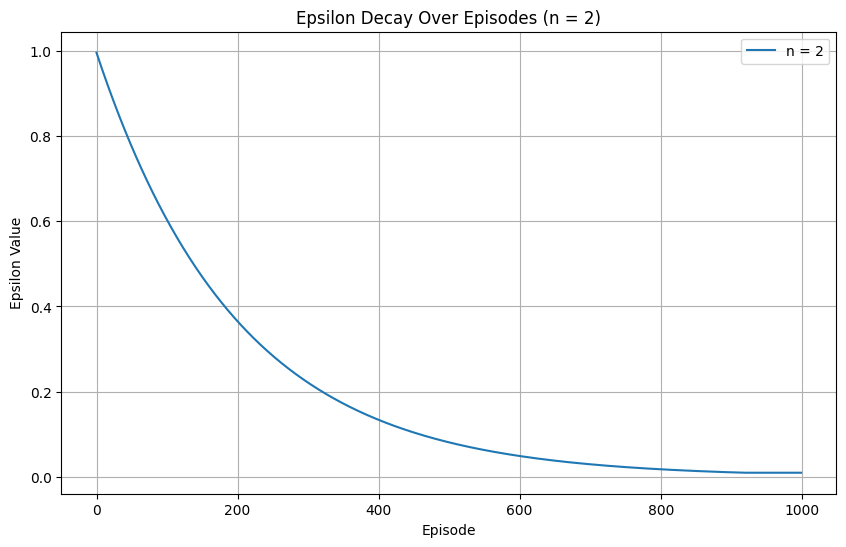

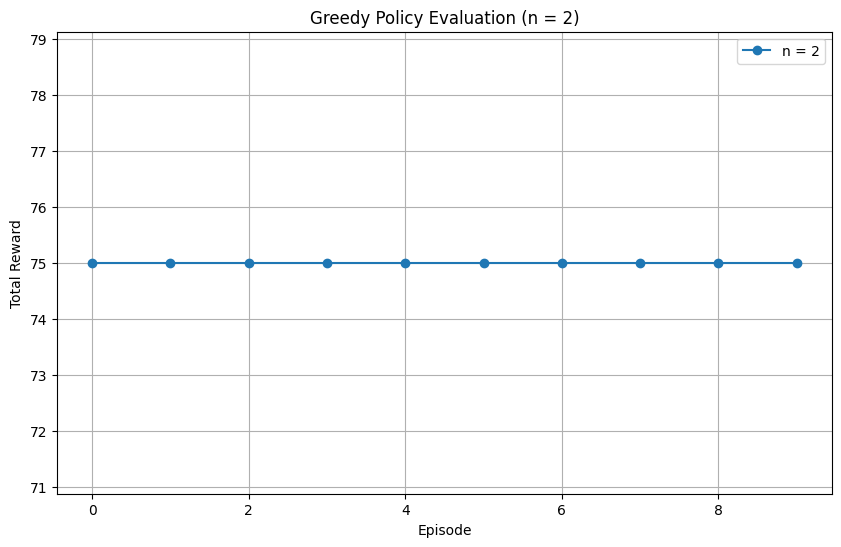

Average greedy reward for n = 2: 75.0

Training with n = 3

Initial Q-tables for n = 3:
Initial Q1 Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
Initial Q2 Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0

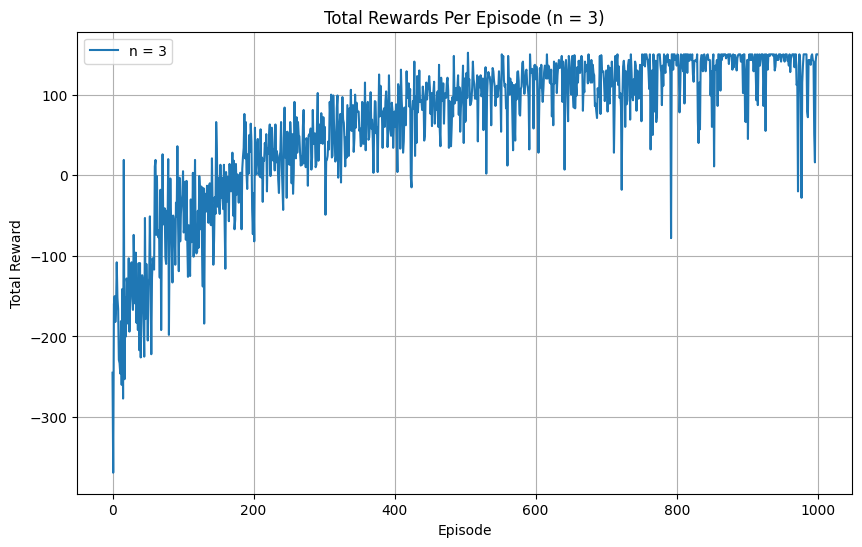

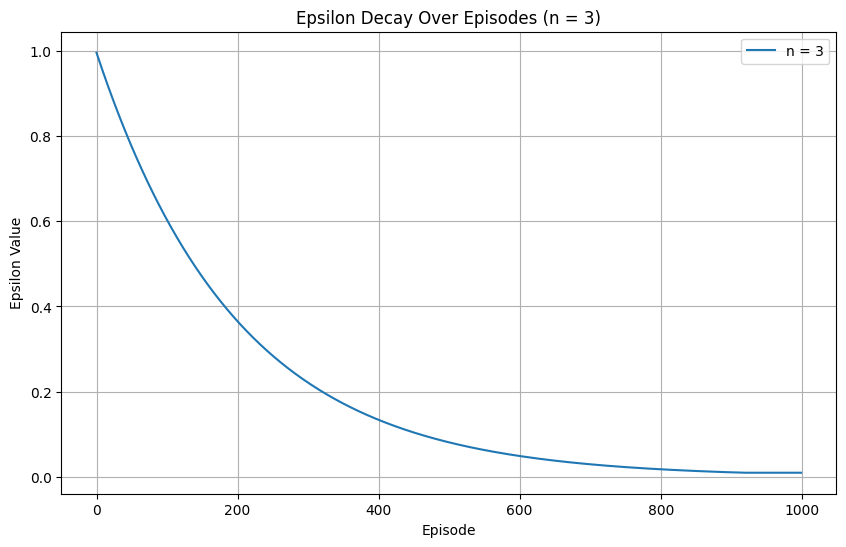

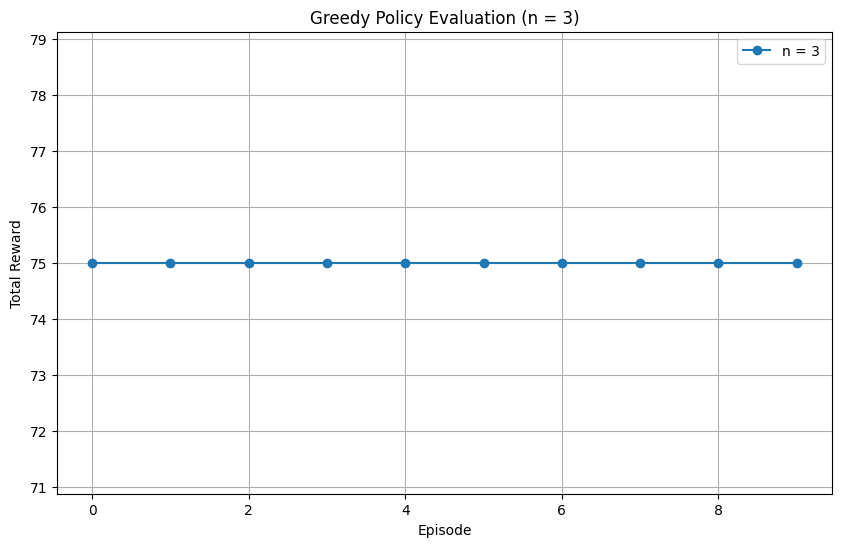

Average greedy reward for n = 3: 75.0

Training with n = 4

Initial Q-tables for n = 4:
Initial Q1 Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
Initial Q2 Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0

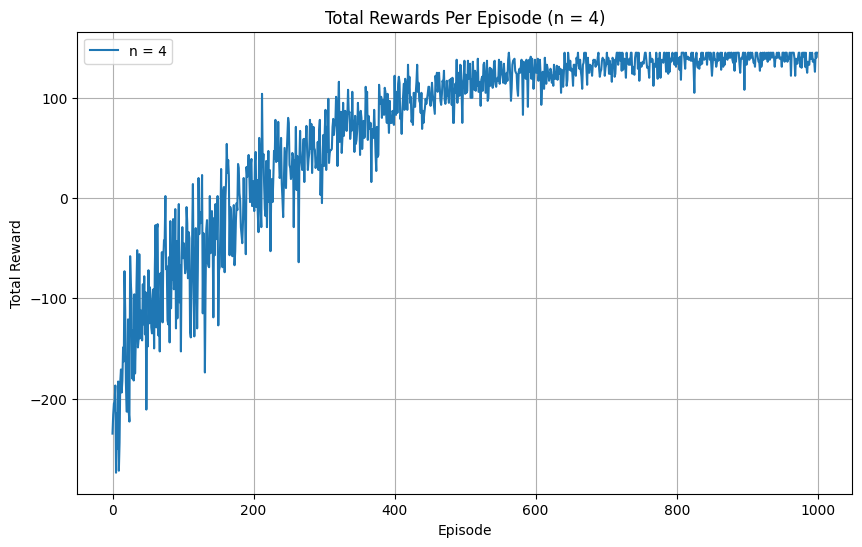

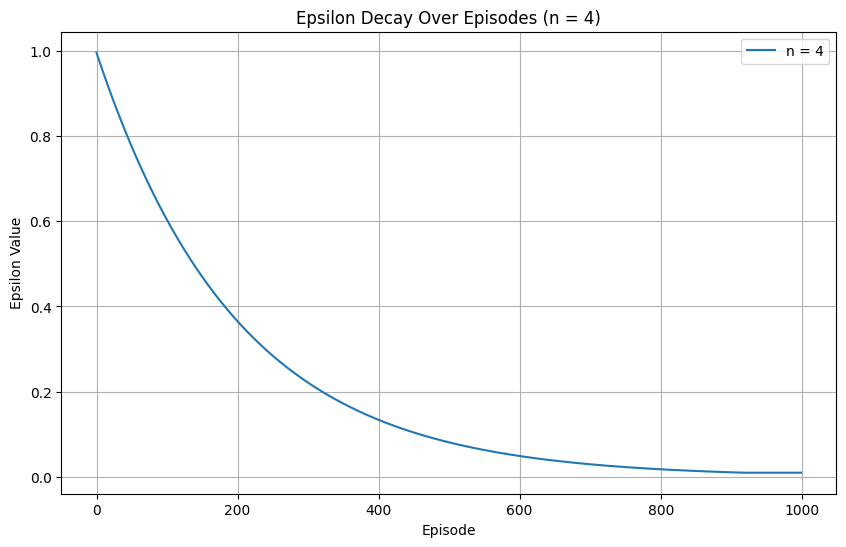

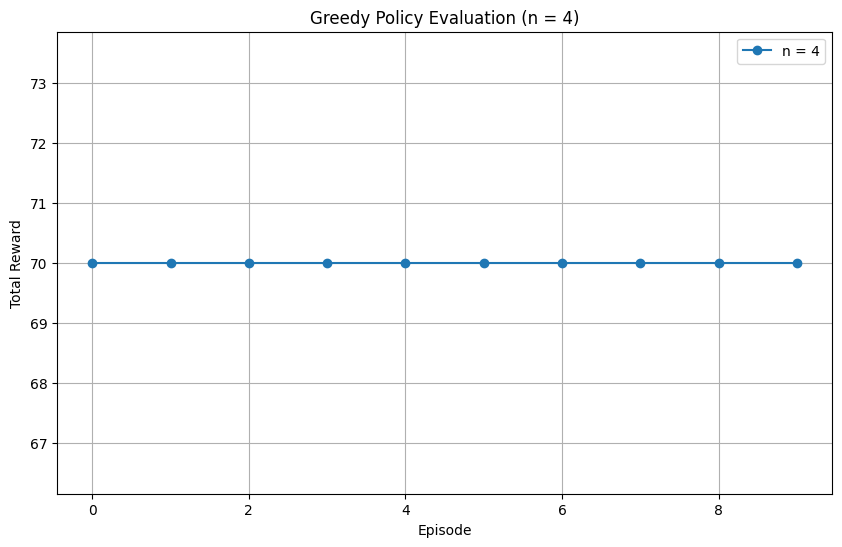

Average greedy reward for n = 4: 70.0

Training with n = 5

Initial Q-tables for n = 5:
Initial Q1 Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
Initial Q2 Table:
[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0

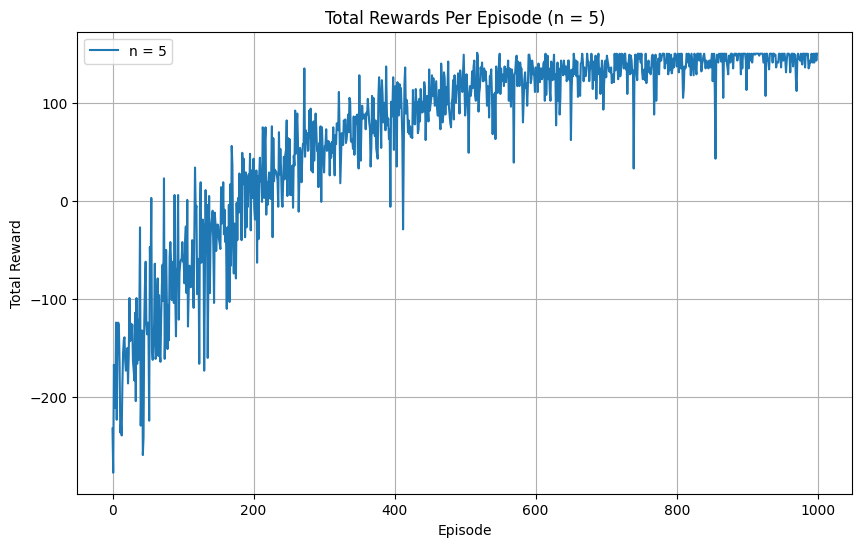

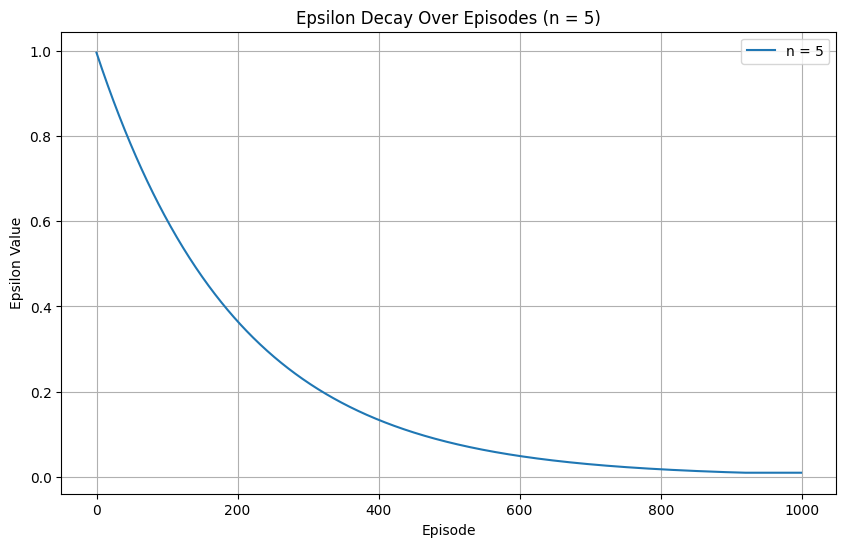

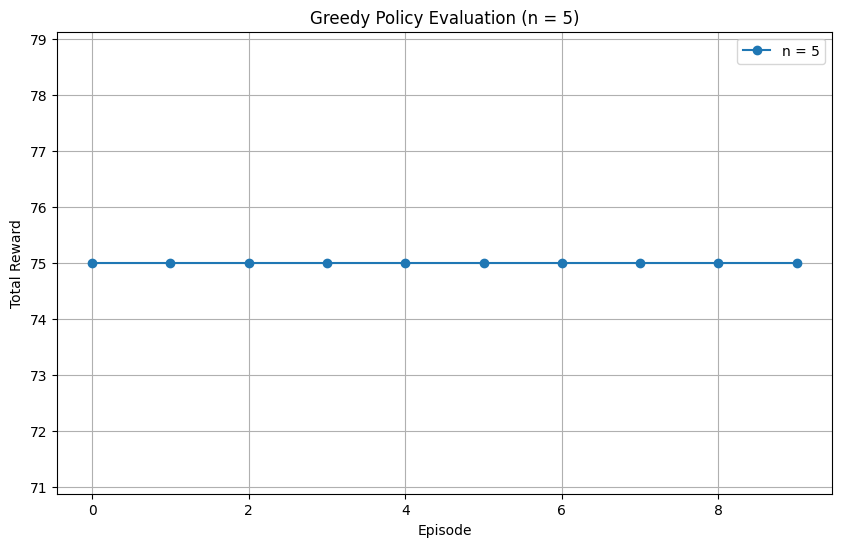

Average greedy reward for n = 5: 75.0


In [ ]:
n_values = [1, 2, 3, 4, 5]

# Initialize variables to track best performance
max_reward = -np.inf
best_n = None

for n in n_values:
    print(f"\nTraining with n = {n}")

    # Initialize the agent with the current n
    agent = DoubleQAgent(env, n_steps=n, alpha=0.1, gamma=double_Q_best_params['gamma'],
                         epsilon=double_Q_best_params['epsilon_max'], epsilon_decay=double_Q_best_params['epsilon_decay'],
                         epsilon_min=double_Q_best_params['epsilon_min'])

    # Print initial Q-tables
    print(f"\nInitial Q-tables for n = {n}:")
    print("Initial Q1 Table:")
    print(agent.q1_table)
    print("Initial Q2 Table:")
    print(agent.q2_table)

    # Train the agent
    rewards, epsilons = agent.train(episodes=1000, max_steps=100)

    print(f"\nTrained Q-tables for n = {n}:")
    print("Trained Q1 Table:")
    print(agent.q1_table)
    print("Trained Q2 Table:")
    print(agent.q2_table)

    # Plot total rewards per episode for the current n
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label=f'n = {n}')
    plt.title(f"Total Rewards Per Episode (n = {n})")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()
    plt.legend()
    plt.show()

    # Plot epsilon decay graph for the current n
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, label=f'n = {n}')
    plt.title(f"Epsilon Decay Over Episodes (n = {n})")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.grid()
    plt.legend()
    plt.show()

    greedy_rewards = agent.evaluate(episodes=10, max_steps=50)
    # Plot greedy rewards per episode
    plt.figure(figsize=(10, 6))
    plt.plot(greedy_rewards, marker='o', label=f'n = {n}')
    plt.title(f"Greedy Policy Evaluation (n = {n})")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()
    plt.legend()
    plt.show()

    # Calculate average greedy reward
    avg_greedy_reward = np.mean(greedy_rewards)
    print(f"Average greedy reward for n = {n}: {avg_greedy_reward}")

    # Track the best n based on the average greedy reward
    if avg_greedy_reward > max_reward:
        max_reward = avg_greedy_reward
        best_n = n


In [ ]:
print(f"\nMost efficient n value based on average greedy reward: {best_n}")



Most efficient n value based on average greedy reward: 2


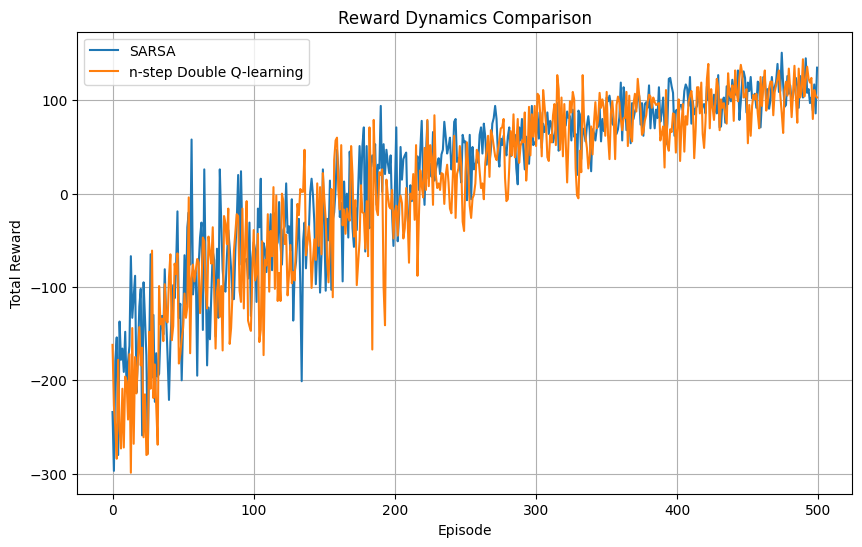

In [ ]:
# Initialize and train SARSA agent on its best parameters
SARSA_agent = SARSAAgent(env, alpha=0.1, gamma=best_params['gamma'], epsilon=1.0, epsilon_decay=best_params['epsilon_decay'])
SARSA_rewards, _ = SARSA_agent.train(episodes=500, max_steps=100)

# Initialize and train Double Q-learning agent on its best parameters
double_q_agent = DoubleQAgent(env, n_steps= best_n, alpha=0.1, gamma=double_Q_best_params['gamma'],
                         epsilon=double_Q_best_params['epsilon_max'], epsilon_decay=double_Q_best_params['epsilon_decay'],
                         epsilon_min=double_Q_best_params['epsilon_min'])
double_q_rewards, _ = double_q_agent.train(episodes=500, max_steps=100)

plt.figure(figsize=(10, 6))
plt.plot(SARSA_rewards, label='SARSA')
plt.plot(double_q_rewards, label='n-step Double Q-learning')
plt.title('Reward Dynamics Comparison')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()